# Notebook 03d: Correlation Analysis & Redundancy Reduction

**Autor:** Silas Pignotti  
**Datum:** Januar 2026  
**Version:** 1.0

---

## 1. OVERVIEW & METHODOLOGY

### 1.1 Purpose

This notebook performs **intra-class correlation analysis** to eliminate redundant features within spectral feature groups. The analysis ensures:

1. **Feature Efficiency:** Remove highly correlated features (|r| > 0.95) within each class
2. **Information Preservation:** Keep features with distinct spectral/phenological information
3. **Cross-City Validation:** Quick check that spectral features generalize across cities

**Key Decision:** Only analyze correlations **within** feature classes (Spectral Bands, VIs, etc.), not between classes. CHM features are excluded from correlation analysis (already filtered in 03c).

**Input:** Final CHM-filtered datasets from 03c_chm_relevance_assessment.ipynb  
**Output:** Correlation-reduced datasets with redundant features removed

### 1.2 Workflow

```
[PHASE 1: SETUP & FEATURE CLASSIFICATION]
├── Step 1.1: Load CHM-filtered datasets
├── Step 1.2: Classify features into groups
│   ├── Spectral Bands (B02-B12)
│   ├── Broadband VIs (NDVI, EVI, VARI, ...)
│   ├── Red-Edge VIs (NDVIre, CIre, ...)
│   ├── Water/Moisture VIs (NDWI, MSI, ...)
│   └── CHM (excluded from correlation analysis)
└── Step 1.3: Export feature inventory

↓

[PHASE 2: INTRA-CLASS CORRELATION ANALYSIS]
├── Step 2.1: Calculate correlation matrices (per class)
├── Step 2.2: Identify redundant pairs (|r| > 0.95)
├── Step 2.3: Apply priority rules → decide KEEP/REMOVE
└── Step 2.4: Visualize correlation heatmaps

↓

[PHASE 2.5: TEMPORAL PATTERN VALIDATION (Quick Check)]
├── Step 2.5.1: Plot NDVI temporal profiles (Top 5 genera)
├── Step 2.5.2: Visual inspection: Similar curves across cities?
└── Step 2.5.3: Document findings (validates spectral generalization)

↓

[PHASE 3: TEMPORAL CONSISTENCY]
├── Step 3.1: Expand base-level decisions to all months
│   (If B03 removed → remove B03_03, B03_04, ..., B03_10)
└── Step 3.2: Validate no incomplete time series

↓

[PHASE 4: EXPORT]
├── Step 4.1: Remove redundant features from datasets
├── Step 4.2: Export final GeoPackages
└── Step 4.3: Export metadata & reports

↓

[OUTPUT]
├── trees_correlation_reduced_no_edge.gpkg
├── trees_correlation_reduced_20m_edge.gpkg
├── correlation_analysis_report.json
├── feature_reduction_summary.csv
└── correlation_heatmaps/*.png
```

### 1.3 Expected Outputs

| File | Type | Description |
|------|------|-------------|
| `trees_correlation_reduced_*.gpkg` | GeoPackage | Final datasets (redundant features removed) |
| `correlation_analysis_report.json` | JSON | All correlation matrices + decisions |
| `feature_reduction_summary.csv` | CSV | List of removed features + rationale |
| `intra_class_correlations.json` | JSON | Correlations within each feature class |
| `correlation_heatmaps/*.png` | PNG | Heatmaps per feature class |
| `ndvi_temporal_profiles.png` | PNG | NDVI time series validation plot |

### 1.4 Theoretical Background

#### **Why |r| > 0.95 Threshold?**

**Pearson Correlation (r):**
- Measures linear relationship between two features
- r² represents shared variance
- |r| > 0.95 → r² > 0.90 → features share >90% variance

**Redundancy Criterion:**
- Features with |r| > 0.95 contribute <10% unique information
- Conservative threshold (only near-perfect redundancy)
- Based on literature (Kuhn & Johnson 2013, "Applied Predictive Modeling")

#### **Why Only Intra-Class Correlation?**

**Correlation between classes is EXPECTED:**
- NDVI ↔ B08 (NIR): r ≈ 0.8 is normal (NDVI uses B08)
- EVI ↔ NDVI: r ≈ 0.9 is OK (both measure vegetation, but EVI is atmospheric-corrected)

**Removing between-class features would:**
- Lose complementary information (e.g., NDVI + EVI capture different aspects)
- Reduce model's ability to distinguish subtle genus differences

#### **Priority Rules (Within-Class)**

When two features have |r| > 0.95, keep the one with:
1. **Scientific Standard:** NDVI > GNDVI (more widely used)
2. **Physical Relevance:** B04 > B03 (red more important for NDVI)
3. **Atmospheric Robustness:** EVI > SAVI (better performance)
4. **Broader Applicability:** NDWI > NDII (water content standard)

---

## 2. SETUP & IMPORTS

In [2]:
# Core packages
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
import json
import warnings
from datetime import datetime
import gc

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

print("✓ Imports successful")

✓ Imports successful


In [3]:
# Google Colab: Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2.1 Path Configuration

In [4]:
import shutil
import os

# Base paths
BASE_DIR = Path("/content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit")
DATA_DIR = BASE_DIR / 'data'

# Input: CHM-filtered datasets (from previous step 03_chm_assessment)
DRIVE_INPUT_DIR = DATA_DIR / '02_pipeline' / '04_feature_reduction' / '03_chm_assessment' / 'data'

# Output: Correlation-reduced datasets
BASE_OUTPUT_DIR = DATA_DIR / '02_pipeline' / '04_feature_reduction' / '04_correlation_analysis'
OUTPUT_DATA_DIR = BASE_OUTPUT_DIR / 'data'
OUTPUT_METADATA_DIR = BASE_OUTPUT_DIR / 'metadata'
OUTPUT_FIGURES_DIR = BASE_OUTPUT_DIR / 'plots'
OUTPUT_HEATMAPS_DIR = OUTPUT_FIGURES_DIR / 'correlation_heatmaps'

# Local runtime paths (for faster IO)
LOCAL_INPUT_DIR = Path('/content/data/input')

# Create output directories
OUTPUT_DATA_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_METADATA_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_FIGURES_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_HEATMAPS_DIR.mkdir(parents=True, exist_ok=True)

print(f"✓ Paths configured")
print(f"  Drive Input:  {DRIVE_INPUT_DIR}")
print(f"  Local Input:  {LOCAL_INPUT_DIR}")
print(f"  Output:       {BASE_OUTPUT_DIR}")

✓ Paths configured
  Drive Input:  /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/02_pipeline/04_feature_reduction/03_chm_assessment/data
  Local Input:  /content/data/input
  Output:       /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/02_pipeline/04_feature_reduction/04_correlation_analysis


### 2.2 Visualization Setup

In [5]:
# Publication-ready style
PUBLICATION_STYLE = {
    'style': 'seaborn-v0_8-whitegrid',
    'figsize': (14, 8),
    'dpi_export': 300,
}

def setup_publication_style():
    plt.rcdefaults()
    plt.style.use(PUBLICATION_STYLE['style'])
    sns.set_palette('Set2')
    plt.rcParams['figure.figsize'] = PUBLICATION_STYLE['figsize']
    plt.rcParams['savefig.dpi'] = PUBLICATION_STYLE['dpi_export']
    plt.rcParams['font.size'] = 11
    print("✓ Publication style configured")

setup_publication_style()

✓ Publication style configured


### 2.3 Feature Classification & Priorities

In [6]:
# Feature groups (base names, without month suffix)
FEATURE_CLASSES = {
    'spectral': ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12'],
    'broadband_vi': ['NDVI', 'GNDVI', 'EVI', 'VARI', 'kNDVI', 'SAVI', 'MSAVI'],
    'redge_vi': ['NDVIre', 'NDre1', 'CIre', 'IRECI', 'RTVIcore', 'MCARI'],
    'water_vi': ['NDWI', 'MSI', 'NDII']
}

# Priority order (higher index = higher priority, keep this one)
PRIORITY = {
    'spectral': ['B02', 'B04', 'B08', 'B8A', 'B05', 'B06', 'B11', 'B12', 'B07', 'B03'],
    'broadband_vi': ['NDVI', 'EVI', 'VARI', 'GNDVI', 'kNDVI', 'SAVI', 'MSAVI'],
    'redge_vi': ['NDVIre', 'CIre', 'IRECI', 'NDre1', 'RTVIcore', 'MCARI'],
    'water_vi': ['NDWI', 'MSI', 'NDII']
}

# Correlation threshold
CORRELATION_THRESHOLD = 0.95

# Selected months (from temporal reduction)
SELECTED_MONTHS = [3, 4, 5, 6, 7, 8, 9, 10]

print("Configuration:")
print(f"  Feature classes: {list(FEATURE_CLASSES.keys())}")
print(f"  Correlation threshold: {CORRELATION_THRESHOLD}")
print(f"  Selected months: {SELECTED_MONTHS}")

Configuration:
  Feature classes: ['spectral', 'broadband_vi', 'redge_vi', 'water_vi']
  Correlation threshold: 0.95
  Selected months: [3, 4, 5, 6, 7, 8, 9, 10]


### 2.4 Utility Functions

In [7]:
def parse_feature_name(col: str) -> tuple:
    """
    Extract base feature name and month from column name.

    Examples:
        'NDVI_06' -> ('NDVI', 6)
        'B02_03' -> ('B02', 3)

    Returns:
        tuple: (base_name, month) or (None, None)
    """
    parts = col.split('_')
    if len(parts) >= 2:
        try:
            month = int(parts[-1])
            if 1 <= month <= 12:
                base_name = '_'.join(parts[:-1])
                return base_name, month
        except ValueError:
            pass
    return None, None


def get_temporal_columns(df, base_names, selected_months=SELECTED_MONTHS):
    """
    Get all temporal columns for given base features.

    Args:
        df: DataFrame
        base_names: List of base feature names (e.g., ['NDVI', 'B02'])
        selected_months: List of months to include

    Returns:
        list: Column names matching pattern base_MM
    """
    cols = []
    for col in df.columns:
        base, month = parse_feature_name(col)
        if base in base_names and month in selected_months:
            cols.append(col)
    return cols


print("✓ Utility functions defined")

✓ Utility functions defined


---

## 3. PHASE 1: DATA LOADING & FEATURE CLASSIFICATION

In [8]:
print("Step 1: Copying datasets from Drive to local runtime (for speed)...")
LOCAL_INPUT_DIR.mkdir(parents=True, exist_ok=True)

# Copy logic
copied_files = []
if DRIVE_INPUT_DIR.exists():
    for file_path in DRIVE_INPUT_DIR.glob('*.gpkg'):
        target_path = LOCAL_INPUT_DIR / file_path.name
        # ALWAYS COPY to ensure fresh data
        print(f"  Copying {file_path.name}...")
        shutil.copy2(file_path, target_path)
        copied_files.append(target_path)
else:
    print(f"⚠️ Warning: Input directory not found: {DRIVE_INPUT_DIR}")

print("\nStep 2: Loading CHM-filtered datasets from local runtime...\n")

# Load datasets from LOCAL path
try:
    trees_no_edge = gpd.read_file(LOCAL_INPUT_DIR / 'trees_clean_chm_final_no_edge.gpkg')
    print(f"✓ Loaded no-edge: {len(trees_no_edge):,} trees")
except Exception as e:
    print(f"❌ Error loading no-edge dataset: {e}")

try:
    trees_20m_edge = gpd.read_file(LOCAL_INPUT_DIR / 'trees_clean_chm_final_20m_edge.gpkg')
    print(f"✓ Loaded 20m-edge: {len(trees_20m_edge):,} trees")
except Exception as e:
    print(f"❌ Error loading 20m-edge dataset: {e}")

if 'trees_no_edge' in locals():
    print(f"\nDataset info:")
    print(f"  Cities: {sorted(trees_no_edge['city'].unique())}")
    print(f"  Genera (no-edge): {trees_no_edge['genus_latin'].nunique()}")
    print(f"  Total columns: {len(trees_no_edge.columns)}")

    # Immediate check for B02
    b02_cols = [c for c in trees_no_edge.columns if 'B02' in c]
    if b02_cols:
        print(f"  ✓ SUCCESS: Found {len(b02_cols)} columns for B02 (e.g., {b02_cols[0]})")
    else:
        print(f"  ⚠️ WARNING: Still no B02 columns found. Available 'B' columns:")
        print(f"    {[c for c in trees_no_edge.columns if c.startswith('B')][:10]}...")

Step 1: Copying datasets from Drive to local runtime (for speed)...
  Copying trees_clean_chm_final_no_edge.gpkg...
  Copying trees_clean_chm_final_20m_edge.gpkg...

Step 2: Loading CHM-filtered datasets from local runtime...

✓ Loaded no-edge: 714,676 trees
✓ Loaded 20m-edge: 289,525 trees

Dataset info:
  Cities: ['Berlin', 'Hamburg', 'Rostock']
  Genera (no-edge): 19
  Total columns: 193
  ✓ SUCCESS: Found 8 columns for B02 (e.g., B02_03)


### 3.1 Classify Features into Groups

In [9]:
print("\nClassifying features into groups...\n")

# Identify features per class
feature_inventory = {}

for class_name, base_names in FEATURE_CLASSES.items():
    # Get all temporal columns for this class
    class_cols = get_temporal_columns(trees_no_edge, base_names)

    # Group by base feature
    bases_found = {}
    for col in class_cols:
        base, month = parse_feature_name(col)
        if base not in bases_found:
            bases_found[base] = []
        bases_found[base].append(col)

    feature_inventory[class_name] = {
        'base_features': list(bases_found.keys()),
        'total_columns': len(class_cols),
        'columns_per_base': {k: len(v) for k, v in bases_found.items()}
    }

    print(f"{class_name.upper()}:")
    print(f"  Base features: {len(bases_found)} ({', '.join(bases_found.keys())})")
    print(f"  Total columns: {len(class_cols)}")
    print()

# CHM features (not analyzed for correlation)
chm_cols = [col for col in trees_no_edge.columns
           if col in ['height_m', 'height_m_norm', 'height_m_percentile', 'crown_ratio',
                     'CHM_mean', 'CHM_max', 'CHM_std']]
print(f"CHM features (excluded from correlation): {chm_cols}")

# Metadata (not analyzed)
metadata_cols = ['tree_id', 'genus_latin', 'city', 'species_group', 'tree_type']
if 'geometry' in trees_no_edge.columns:
    metadata_cols.append('geometry')
metadata_cols = [col for col in metadata_cols if col in trees_no_edge.columns]

print(f"\nMetadata columns (excluded): {len(metadata_cols)}")


Classifying features into groups...

SPECTRAL:
  Base features: 10 (B02, B03, B04, B05, B06, B07, B08, B8A, B11, B12)
  Total columns: 80

BROADBAND_VI:
  Base features: 5 (NDVI, GNDVI, EVI, VARI, kNDVI)
  Total columns: 40

REDGE_VI:
  Base features: 5 (NDre1, NDVIre, CIre, IRECI, RTVIcore)
  Total columns: 40

WATER_VI:
  Base features: 3 (NDWI, MSI, NDII)
  Total columns: 24

CHM features (excluded from correlation): ['height_m', 'height_m_norm', 'height_m_percentile', 'crown_ratio']

Metadata columns (excluded): 5


---

## 4. PHASE 2: INTRA-CLASS CORRELATION ANALYSIS

### 4.1 Calculate Correlation Matrices (Per Class)

In [10]:
def analyze_class_correlation(df, class_name, base_names, threshold=CORRELATION_THRESHOLD):
    """
    Analyze correlation within a feature class.

    Returns:
        dict: {
            'correlation_matrix': pd.DataFrame,
            'redundant_pairs': list of (feat1, feat2, r_value),
            'features_to_remove': list of base features
        }
    """
    print(f"\n{'='*60}")
    print(f"Correlation Analysis: {class_name.upper()}")
    print(f"{'='*60}\n")

    # Get columns for this class
    class_cols = get_temporal_columns(df, base_names)

    if len(class_cols) == 0:
        print("  ⚠️  No features found for this class")
        return None

    print(f"  Features to analyze: {len(class_cols)} columns")

    # Sample subset for correlation (to speed up computation)
    sample_size = min(50000, len(df))
    df_sample = df[class_cols].sample(n=sample_size, random_state=42)

    # Calculate correlation matrix
    print(f"  Computing correlation matrix (sample n={sample_size:,})...")
    corr_matrix = df_sample.corr(method='pearson')

    # Find redundant pairs at BASE LEVEL (not individual months)
    # Strategy: Average correlation across all months for each base pair
    base_features = list(set([parse_feature_name(col)[0] for col in class_cols]))

    redundant_pairs = []
    features_to_remove = set()

    for i, base1 in enumerate(base_features):
        for j in range(i+1, len(base_features)):
            base2 = base_features[j]

            # Get all month combinations for this base pair
            correlations = []
            for col1 in class_cols:
                b1, m1 = parse_feature_name(col1)
                if b1 != base1:
                    continue
                for col2 in class_cols:
                    b2, m2 = parse_feature_name(col2)
                    if b2 != base2 or m1 != m2:  # Same month comparison
                        continue
                    r_val = corr_matrix.loc[col1, col2]
                    correlations.append(abs(r_val))

            if len(correlations) == 0:
                continue

            # Average correlation across months
            avg_corr = np.mean(correlations)

            if avg_corr > threshold:
                redundant_pairs.append((base1, base2, avg_corr))

                # Decide which to remove based on priority
                priority_list = PRIORITY[class_name]
                idx1 = priority_list.index(base1) if base1 in priority_list else -1
                idx2 = priority_list.index(base2) if base2 in priority_list else -1

                if idx1 > idx2:
                    remove_base = base1
                else:
                    remove_base = base2

                features_to_remove.add(remove_base)

                print(f"  {base1} ↔ {base2}: r = {avg_corr:.3f} → REMOVE {remove_base}")

    if len(redundant_pairs) == 0:
        print(f"  ✓ No redundant pairs found (all |r| ≤ {threshold})")
    else:
        print(f"\n  Summary:")
        print(f"    Redundant pairs: {len(redundant_pairs)}")
        print(f"    Base features to remove: {len(features_to_remove)} ({', '.join(sorted(features_to_remove))})")

    return {
        'correlation_matrix': corr_matrix,
        'redundant_pairs': redundant_pairs,
        'features_to_remove': list(features_to_remove),
        'base_features': base_features
    }


# Analyze all classes
correlation_results = {}

for class_name, base_names in FEATURE_CLASSES.items():
    result = analyze_class_correlation(trees_no_edge, class_name, base_names)
    if result:
        correlation_results[class_name] = result


Correlation Analysis: SPECTRAL

  Features to analyze: 80 columns
  Computing correlation matrix (sample n=50,000)...
  B02 ↔ B03: r = 0.956 → REMOVE B03
  B07 ↔ B06: r = 0.967 → REMOVE B07
  B07 ↔ B8A: r = 0.982 → REMOVE B07

  Summary:
    Redundant pairs: 3
    Base features to remove: 2 (B03, B07)

Correlation Analysis: BROADBAND_VI

  Features to analyze: 40 columns
  Computing correlation matrix (sample n=50,000)...
  kNDVI ↔ GNDVI: r = 0.957 → REMOVE kNDVI
  kNDVI ↔ NDVI: r = 0.991 → REMOVE kNDVI
  GNDVI ↔ NDVI: r = 0.969 → REMOVE GNDVI

  Summary:
    Redundant pairs: 3
    Base features to remove: 2 (GNDVI, kNDVI)

Correlation Analysis: REDGE_VI

  Features to analyze: 40 columns
  Computing correlation matrix (sample n=50,000)...
  ✓ No redundant pairs found (all |r| ≤ 0.95)

Correlation Analysis: WATER_VI

  Features to analyze: 24 columns
  Computing correlation matrix (sample n=50,000)...
  NDWI ↔ MSI: r = 0.978 → REMOVE MSI

  Summary:
    Redundant pairs: 1
    Base fea

### 4.2 Visualize Correlation Heatmaps

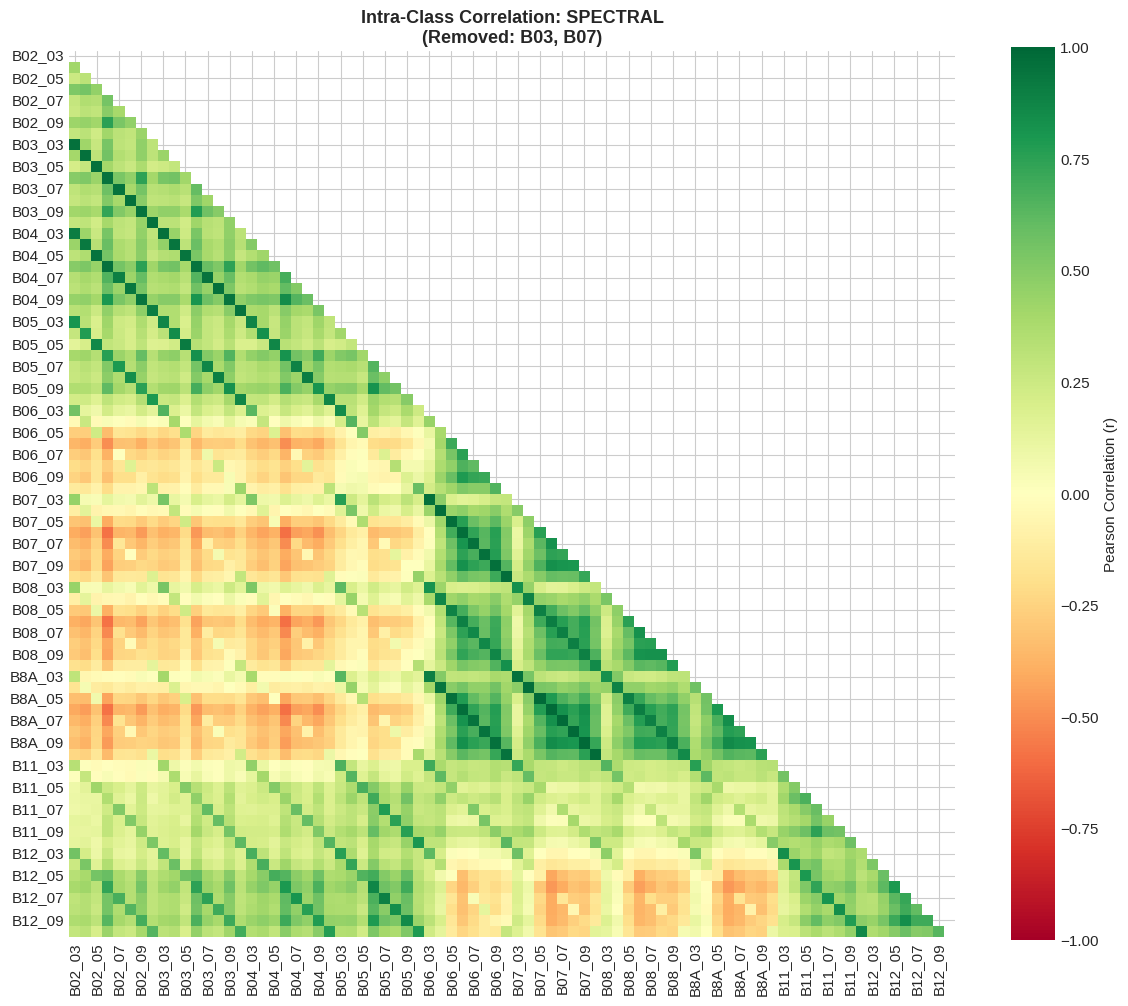

✓ Heatmap saved: spectral_correlation_heatmap.png


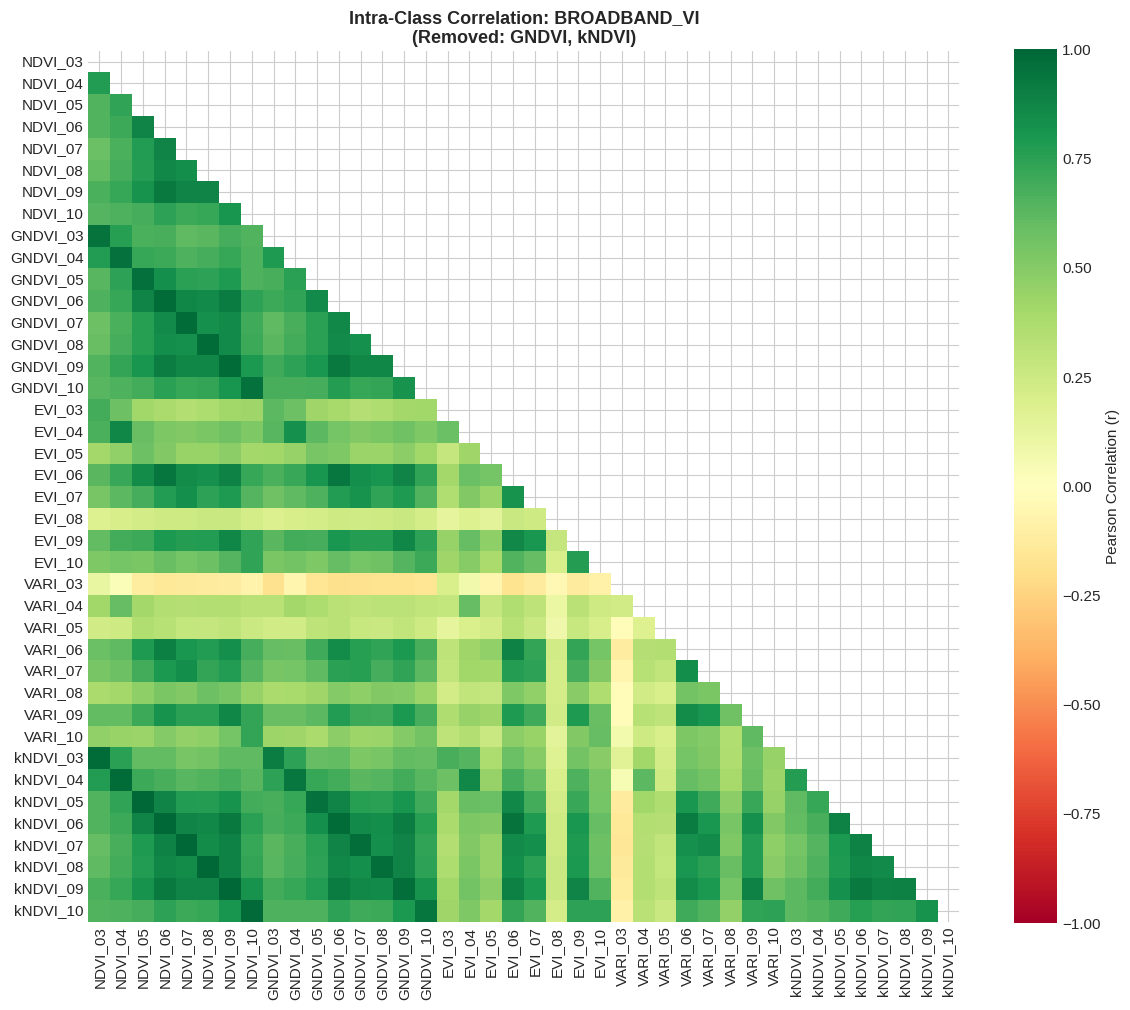

✓ Heatmap saved: broadband_vi_correlation_heatmap.png


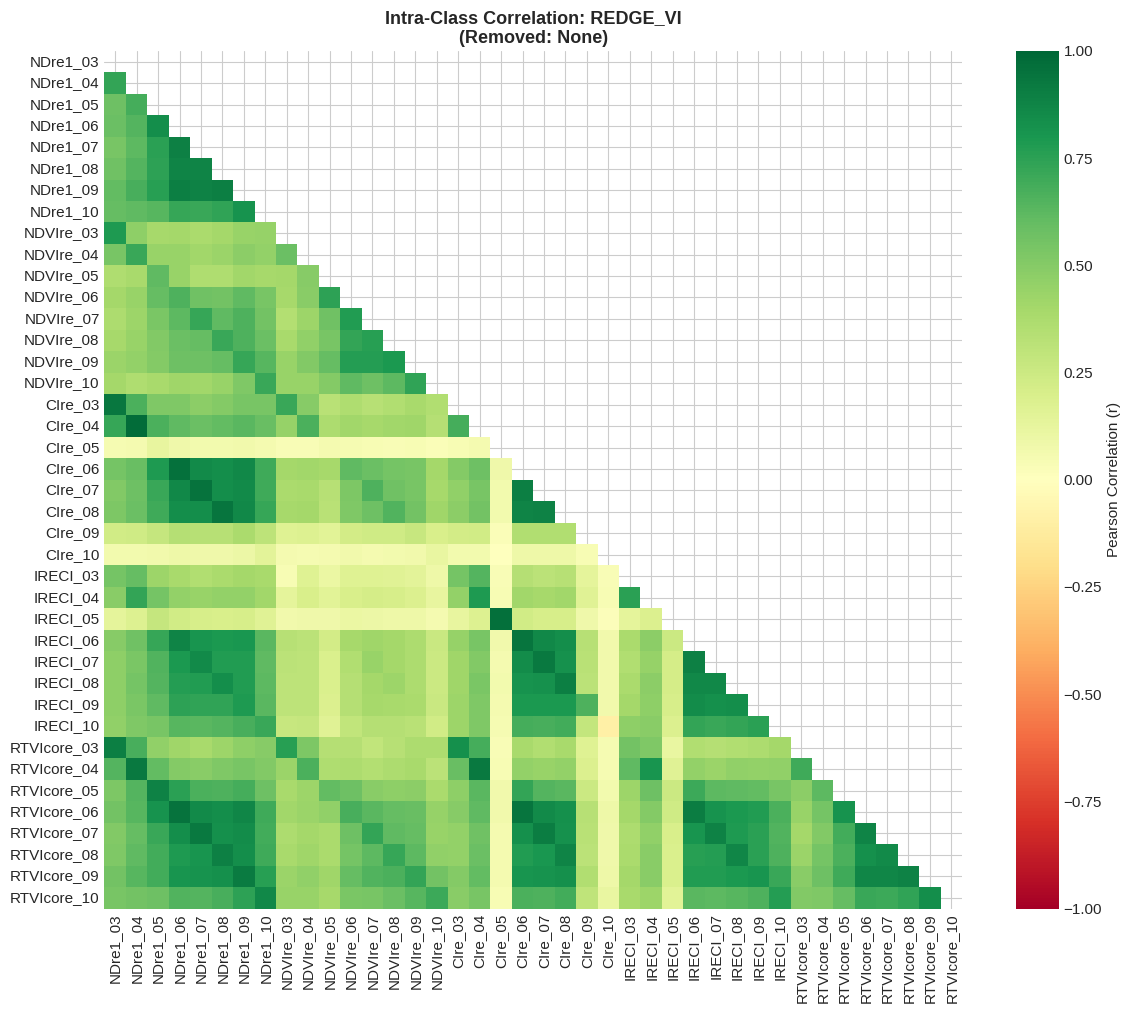

✓ Heatmap saved: redge_vi_correlation_heatmap.png


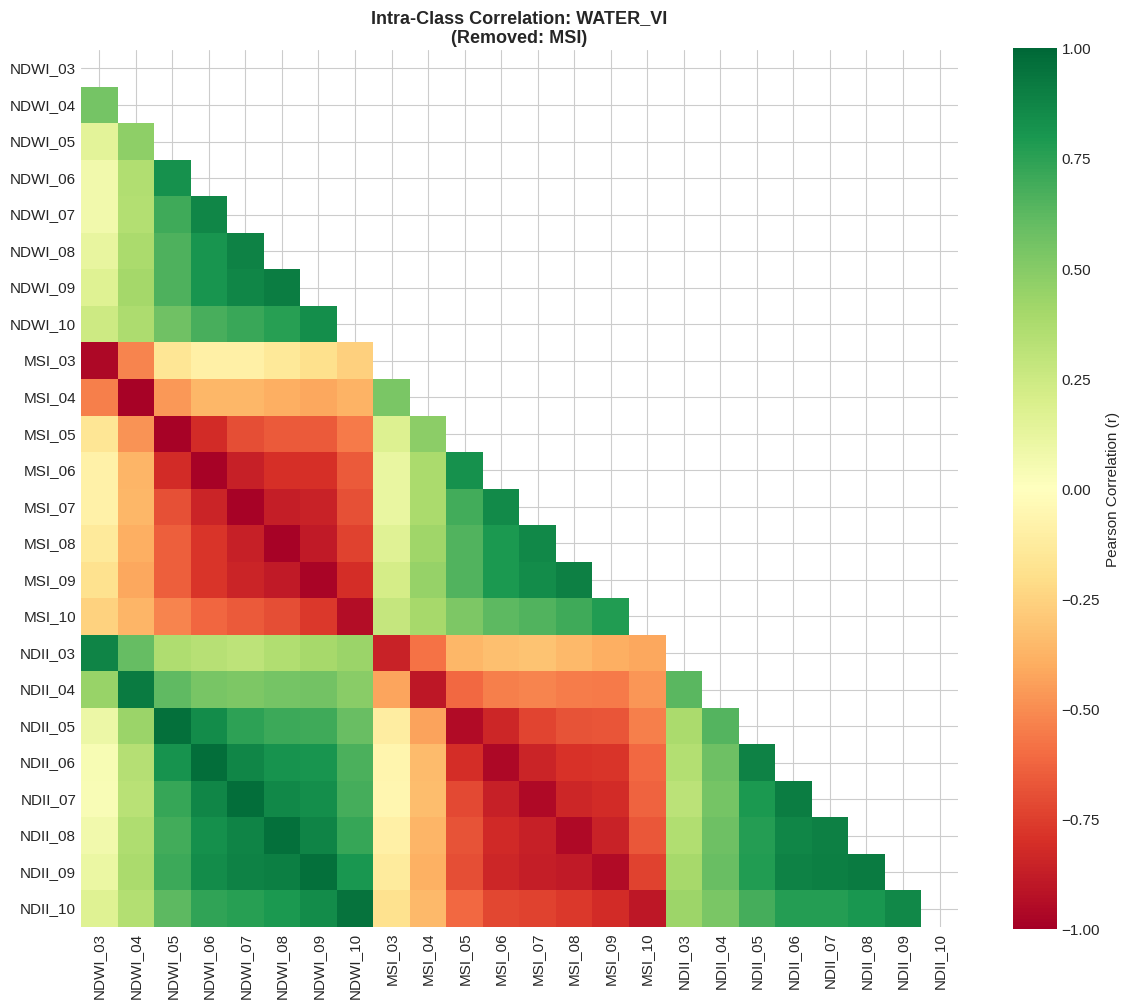

✓ Heatmap saved: water_vi_correlation_heatmap.png

✓ All correlation heatmaps saved to: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/02_pipeline/04_feature_reduction/04_correlation_analysis/plots/correlation_heatmaps


In [12]:
# Plot correlation heatmaps for each class
for class_name, result in correlation_results.items():
    corr_matrix = result['correlation_matrix']
    features_to_remove = result['features_to_remove']

    # Only plot if matrix is not too large
    if len(corr_matrix) > 100:
        print(f"  Skipping heatmap for {class_name} (too many features: {len(corr_matrix)})")
        continue

    fig, ax = plt.subplots(figsize=(12, 10))

    # Create mask for upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Plot heatmap
    sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='RdYlGn',
               vmin=-1, vmax=1, center=0, square=True, ax=ax,
               cbar_kws={'label': 'Pearson Correlation (r)'})

    ax.set_title(f'Intra-Class Correlation: {class_name.upper()}\n' +
                f'(Removed: {', '.join(features_to_remove) if features_to_remove else "None"})',
                fontsize=13, fontweight='bold')

    plt.tight_layout()
    plt.savefig(OUTPUT_HEATMAPS_DIR / f'{class_name}_correlation_heatmap.png',
               dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✓ Heatmap saved: {class_name}_correlation_heatmap.png")

print(f"\n✓ All correlation heatmaps saved to: {OUTPUT_HEATMAPS_DIR}")

---

## 5. PHASE 2.5: TEMPORAL PATTERN VALIDATION (Quick Check)

### 5.1 NDVI Temporal Profiles (Cross-City Validation)

**Purpose:** Visual confirmation that spectral features (NDVI as proxy) show similar phenological patterns across cities.

**Expected:** Similar curve shapes (peak in June/July), slight offsets are acceptable.

**Interpretation:**
- ✓ Similar curves → Spectral features generalize well
- ⚠️ Very different peaks → City-specific effects (would need further investigation)

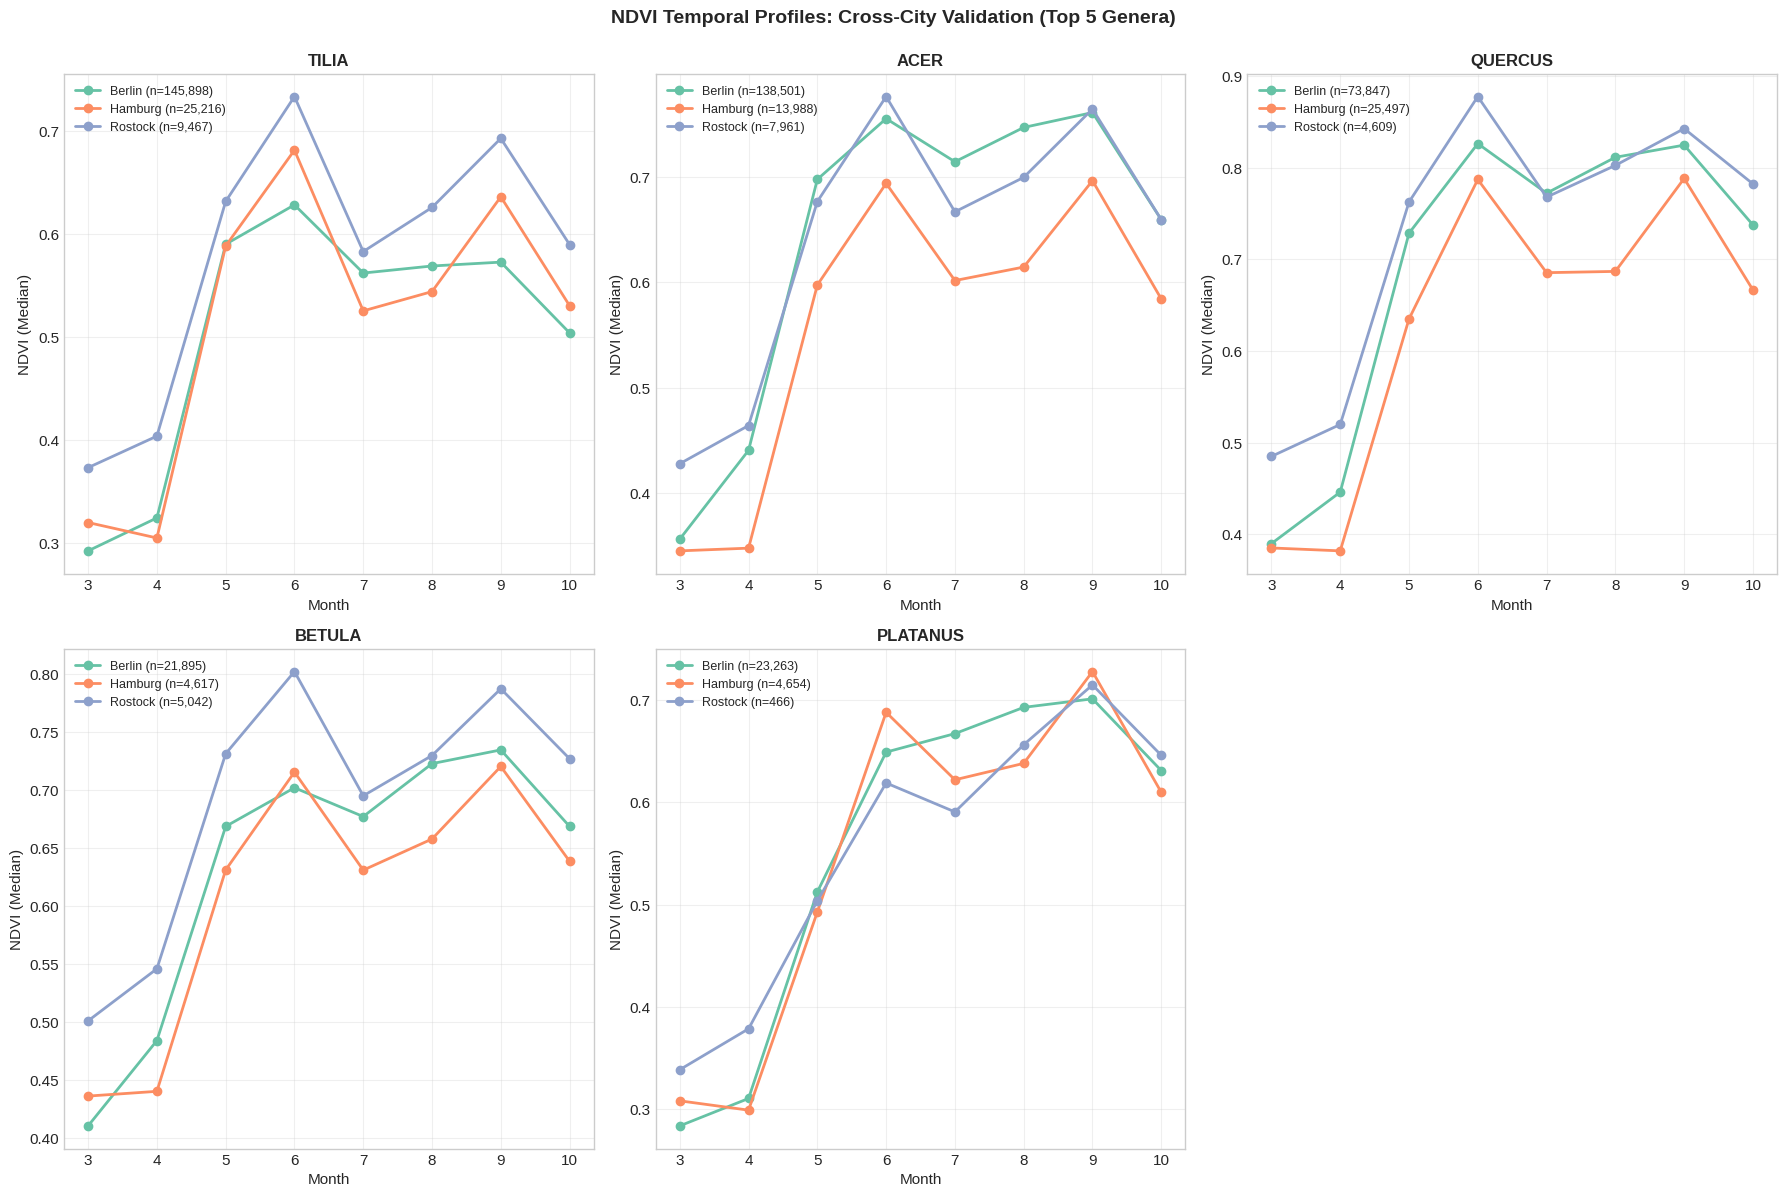

✓ NDVI temporal profile plot saved

Interpretation:
  If curves show similar shapes across cities:
    → ✓ Confirms spectral features generalize well
  If curves are very different:
    → ⚠️ May indicate city-specific effects requiring further analysis


In [13]:
# Select top 5 genera by sample size
top_genera = trees_no_edge['genus_latin'].value_counts().head(5).index.tolist()

# Get NDVI columns
ndvi_cols = [f'NDVI_{m:02d}' for m in SELECTED_MONTHS]

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, genus in enumerate(top_genera):
    ax = axes[idx]

    # Plot NDVI profile per city
    for city in sorted(trees_no_edge['city'].unique()):
        subset = trees_no_edge[(trees_no_edge['genus_latin'] == genus) &
                               (trees_no_edge['city'] == city)]

        if len(subset) < 10:
            continue

        # Calculate median NDVI per month
        ndvi_profile = subset[ndvi_cols].median()

        # Plot
        ax.plot(SELECTED_MONTHS, ndvi_profile.values, marker='o',
               label=f'{city} (n={len(subset):,})', linewidth=2, markersize=6)

    ax.set_title(f'{genus}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Month', fontsize=11)
    ax.set_ylabel('NDVI (Median)', fontsize=11)
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(SELECTED_MONTHS)

# Remove extra subplot
fig.delaxes(axes[5])

plt.suptitle('NDVI Temporal Profiles: Cross-City Validation (Top 5 Genera)',
            fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(OUTPUT_FIGURES_DIR / 'ndvi_temporal_profiles.png',
           dpi=300, bbox_inches='tight')
plt.show()

print("✓ NDVI temporal profile plot saved")
print("\nInterpretation:")
print("  If curves show similar shapes across cities:")
print("    → ✓ Confirms spectral features generalize well")
print("  If curves are very different:")
print("    → ⚠️ May indicate city-specific effects requiring further analysis")

---

## 6. PHASE 3: TEMPORAL CONSISTENCY

### 6.1 Expand Base-Level Decisions to All Months

In [14]:
print(f"\n{'='*60}")
print("TEMPORAL CONSISTENCY: Expanding base-level decisions")
print(f"{'='*60}\n")

# Collect all base features to remove (across all classes)
all_bases_to_remove = []
removal_rationale = {}

for class_name, result in correlation_results.items():
    bases_to_remove = result['features_to_remove']
    redundant_pairs = result['redundant_pairs']

    for base in bases_to_remove:
        all_bases_to_remove.append(base)

        # Find which pair caused removal
        for b1, b2, r_val in redundant_pairs:
            if base in [b1, b2]:
                other = b1 if base == b2 else b2
                removal_rationale[base] = {
                    'class': class_name,
                    'correlated_with': other,
                    'correlation': round(r_val, 3),
                    'reason': f'High correlation with {other} (r={r_val:.3f})'
                }
                break

# Expand to all temporal columns
all_cols_to_remove = []

for base in all_bases_to_remove:
    # Find all columns with this base
    for month in SELECTED_MONTHS:
        col_name = f"{base}_{month:02d}"
        if col_name in trees_no_edge.columns:
            all_cols_to_remove.append(col_name)

print(f"Base features to remove: {len(set(all_bases_to_remove))}")
print(f"  {', '.join(sorted(set(all_bases_to_remove)))}")
print(f"\nTotal temporal columns to remove: {len(all_cols_to_remove)}")
print(f"  (= {len(set(all_bases_to_remove))} bases × {len(SELECTED_MONTHS)} months)")

# Validation: Check no incomplete time series
print(f"\nValidation:")
for base in set(all_bases_to_remove):
    expected_cols = [f"{base}_{m:02d}" for m in SELECTED_MONTHS]
    found_cols = [col for col in all_cols_to_remove if col in expected_cols]

    if len(found_cols) != len(SELECTED_MONTHS):
        print(f"  ⚠️  {base}: Only {len(found_cols)}/{len(SELECTED_MONTHS)} months found")
    else:
        print(f"  ✓ {base}: All {len(SELECTED_MONTHS)} months marked for removal")


TEMPORAL CONSISTENCY: Expanding base-level decisions

Base features to remove: 5
  B03, B07, GNDVI, MSI, kNDVI

Total temporal columns to remove: 40
  (= 5 bases × 8 months)

Validation:
  ✓ B03: All 8 months marked for removal
  ✓ B07: All 8 months marked for removal
  ✓ kNDVI: All 8 months marked for removal
  ✓ GNDVI: All 8 months marked for removal
  ✓ MSI: All 8 months marked for removal


---

## 7. PHASE 4: EXPORT

### 7.1 Remove Redundant Features from Datasets

In [15]:
print(f"\n{'='*60}")
print("EXPORT: Removing redundant features")
print(f"{'='*60}\n")

# Filter both datasets
cols_before_no = len(trees_no_edge.columns)
cols_before_20m = len(trees_20m_edge.columns)

# Keep all columns EXCEPT the ones to remove
keep_cols = [col for col in trees_no_edge.columns if col not in all_cols_to_remove]

trees_no_edge_final = trees_no_edge[keep_cols].copy()
trees_20m_edge_final = trees_20m_edge[keep_cols].copy()

print(f"No-Edge Dataset:")
print(f"  Columns before: {cols_before_no}")
print(f"  Columns removed: {len(all_cols_to_remove)}")
print(f"  Columns after: {len(trees_no_edge_final.columns)}")
print(f"  Trees: {len(trees_no_edge_final):,}")

print(f"\n20m-Edge Dataset:")
print(f"  Columns before: {cols_before_20m}")
print(f"  Columns removed: {len(all_cols_to_remove)}")
print(f"  Columns after: {len(trees_20m_edge_final.columns)}")
print(f"  Trees: {len(trees_20m_edge_final):,}")

# Memory cleanup
del trees_no_edge, trees_20m_edge
gc.collect()
print("\n✓ Memory cleaned")


EXPORT: Removing redundant features

No-Edge Dataset:
  Columns before: 193
  Columns removed: 40
  Columns after: 153
  Trees: 714,676

20m-Edge Dataset:
  Columns before: 193
  Columns removed: 40
  Columns after: 153
  Trees: 289,525

✓ Memory cleaned


### 7.2 Export Final GeoPackages

In [16]:
print("\nExporting final GeoPackages...\n")

# Export no-edge
output_no_edge = OUTPUT_DATA_DIR / 'trees_correlation_reduced_no_edge.gpkg'
trees_no_edge_final.to_file(output_no_edge, driver='GPKG')
print(f"✓ Exported: {output_no_edge.name}")
print(f"  Trees: {len(trees_no_edge_final):,}")
print(f"  Features: {len(trees_no_edge_final.columns)}")

# Export 20m-edge
output_20m_edge = OUTPUT_DATA_DIR / 'trees_correlation_reduced_20m_edge.gpkg'
trees_20m_edge_final.to_file(output_20m_edge, driver='GPKG')
print(f"\n✓ Exported: {output_20m_edge.name}")
print(f"  Trees: {len(trees_20m_edge_final):,}")
print(f"  Features: {len(trees_20m_edge_final.columns)}")


Exporting final GeoPackages...

✓ Exported: trees_correlation_reduced_no_edge.gpkg
  Trees: 714,676
  Features: 153

✓ Exported: trees_correlation_reduced_20m_edge.gpkg
  Trees: 289,525
  Features: 153


### 7.3 Export Metadata & Reports

In [ ]:
print("\nExporting metadata...\n")

# 1. Feature Reduction Summary CSV
reduction_summary = []
for base in sorted(set(all_bases_to_remove)):
    if base in removal_rationale:
        info = removal_rationale[base]
        reduction_summary.append({
            'removed_feature': base,
            'feature_class': info['class'],
            'correlated_with': info['correlated_with'],
            'correlation': info['correlation'],
            'reason': info['reason'],
            'temporal_columns_removed': len(SELECTED_MONTHS)
        })

reduction_df = pd.DataFrame(reduction_summary)
reduction_path = OUTPUT_METADATA_DIR / 'feature_reduction_summary.csv'
reduction_df.to_csv(reduction_path, index=False)
print(f"✓ Exported: {reduction_path.name}")

# 2. Correlation Analysis Report JSON
report = {
    'processing_date': datetime.now().isoformat(),
    'configuration': {
        'correlation_threshold': CORRELATION_THRESHOLD,
        'selected_months': SELECTED_MONTHS,
        'analysis_method': 'Pairwise Pearson correlation (intra-class only)'
    },
    'feature_inventory': feature_inventory,
    'removed_features': {
        'base_features': sorted(set(all_bases_to_remove)),
        'total_columns': len(all_cols_to_remove),
        'by_class': {}
    },
    'final_counts': {
        'no_edge': {
            'trees': len(trees_no_edge_final),
            'features': len(trees_no_edge_final.columns)
        },
        '20m_edge': {
            'trees': len(trees_20m_edge_final),
            'features': len(trees_20m_edge_final.columns)
        }
    }
}

# Add by-class breakdown
for class_name, result in correlation_results.items():
    report['removed_features']['by_class'][class_name] = {
        'removed_bases': result['features_to_remove'],
        'redundant_pairs': len(result['redundant_pairs'])
    }

report_path = OUTPUT_METADATA_DIR / 'correlation_analysis_report.json'
with open(report_path, 'w') as f:
    json.dump(report, f, indent=2)
print(f"✓ Exported: {report_path.name}")

# 3. Intra-Class Correlations JSON (full matrices would be too large, save summary)
intra_class_summary = {}
for class_name, result in correlation_results.items():
    corr_matrix = result['correlation_matrix']

    # Summary statistics
    # Get lower triangle (excluding diagonal)
    mask = np.tril(np.ones_like(corr_matrix, dtype=bool), k=-1)
    lower_triangle = corr_matrix.where(mask)

    intra_class_summary[class_name] = {
        'n_features': len(corr_matrix),
        'mean_correlation': float(lower_triangle.stack().mean()),
        'max_correlation': float(lower_triangle.stack().max()),
        'min_correlation': float(lower_triangle.stack().min()),
        'n_high_correlation': int((lower_triangle.abs() > CORRELATION_THRESHOLD).sum().sum()),
        'redundant_pairs': result['redundant_pairs']
    }

intra_corr_path = OUTPUT_METADATA_DIR / 'intra_class_correlations.json'
with open(intra_corr_path, 'w') as f:
    json.dump(intra_class_summary, f, indent=2)
print(f"✓ Exported: {intra_corr_path.name}")

print(f"\n{'='*60}")
print("CORRELATION ANALYSIS COMPLETE")
print(f"{'='*60}")
print(f"\nOutputs saved to: {OUTPUT_DATA_DIR}")
print(f"  Data: 2 GeoPackages (trees_correlation_reduced_*.gpkg)")
print(f"    → Redundant features removed: {len(set(all_bases_to_remove))} bases")
print(f"  Metadata: 3 files (CSV, JSON×2)")
print(f"  Figures: {len(list(OUTPUT_HEATMAPS_DIR.glob('*.png')))} heatmaps + 1 temporal profile")
print(f"\n✓ Ready for next step: Outlier Detection (Notebook 03e)")

---

**Notebook End**

**Next Notebook:** `03e_outlier_detection.ipynb`  
**Input for Next Step:** `trees_correlation_reduced_*.gpkg`

**Key Outputs:**
- Redundant features removed based on intra-class correlation (|r| > 0.95)
- NDVI temporal patterns validated across cities
- Datasets ready for outlier detection and final filtering

**Author:** Silas Pignotti  
**Date:** Januar 2026